# Traffic Light Identification and Classification
Senior Project
Team PineApple

# Setup

## Importing Packages

In [1]:
import time
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import yaml # read yaml file
import os # For file path
import cv2 # For image processing
import sklearn as sk # For machine learning

import matplotlib.pyplot as plt
import tensorflow as tf
from shutil import copyfile

import torch # For neural network
from PIL import Image, ImageDraw, ImageFont
import random

## Data Pre-Processing

Data available at https://hci.iwr.uni-heidelberg.de/content/bosch-small-traffic-lights-dataset

In [2]:
train_file_path = 'train.yaml'

In [3]:
train_key = yaml.load(open(train_file_path), Loader=yaml.FullLoader)

In [4]:
def annotatePicture(dictEntry):
    img = cv2.imread(dictEntry['path']).copy()
    for i in dictEntry['boxes']: 
        startPoint = (int(i['x_min']), int(i['y_min']))
        endPoint = (int(i['x_max']), int(i['y_max']))
        cv2.rectangle(img, startPoint, endPoint, (0,255,0), 2)
    return img

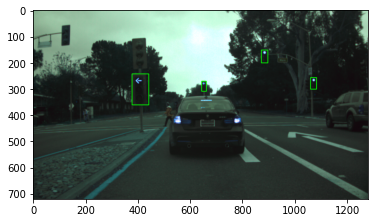

In [5]:
# Used to show test output
img = annotatePicture(train_key[23])
plt.imshow(img)

## Data Formatting

### Data Encoding

In [6]:
# Displaying encoding labels
labels = []
for i in range(len(train_key)):
    for boxes in train_key[i]['boxes']:
                if(boxes['label'] not in labels):
                    labels.append(boxes['label'])
labelDict = {}
for i in labels:
    labelDict[i] = labels.index(i)
print(labelDict)

{'Yellow': 0, 'RedLeft': 1, 'Red': 2, 'GreenLeft': 3, 'Green': 4, 'off': 5, 'GreenRight': 6, 'GreenStraight': 7, 'GreenStraightRight': 8, 'RedRight': 9, 'RedStraight': 10, 'RedStraightLeft': 11, 'GreenStraightLeft': 12}


In [7]:
! cd dataset/; rm **/*.png; rm **/*.txt; rm **/*.cache; cd ../;

zsh:1: no matches found: **/*.cache


### Convert to YOLO annotation format

In [8]:
def makeAnnotations(train_key, numImages, labelDict, path):
    # For all images
    count = 0
    for i in range(len(train_key)):
        if(train_key[i]['boxes'] != []):
            filePath = train_key[i]['path']
            indexOfName = filePath.rfind('/') + 1 # Get index of last '/'
            annotationPath = filePath[indexOfName:].replace(".png", ".txt") # Get shortened name of file
            copyfile(filePath, path + "images/" + annotationPath.replace(".txt", ".png")) # Copy img to new location
            
            f = open(path + "labels/" + annotationPath, 'w') # .txt annotation file to make
            f.truncate(0)
            img_height, img_width = (720, 1280)
            # For all boxes
            for boxes in train_key[i]['boxes']:
                xmin = int(boxes['x_min'])
                ymin = int(boxes['y_min'])
                xmax = int(boxes['x_max'])
                ymax = int(boxes['y_max'])
                dw = 1./img_width
                dh = 1./img_height
                if(xmax - xmin < 5 or ymax - ymin < 5):
                    break
                x = (xmin + xmax) / 2.0 - 1
                y = (ymin + ymax) / 2.0 - 1
                w = xmax - xmin
                h = ymax - ymin
                
                x = x * dw # Yolo x
                y = y * dh # Yolo y
                w = w * dw # Yolo width
                h = h * dh # Yolo height
                
                yolo_label = labelDict[boxes['label']]
                f.write(str(yolo_label) + " " + str(x)[0:8] + " " + str(y)[0:8] + " " + str(w)[0:8] + " " + str(h)[0:8] + "\n")
            f.close()
            count += 1
        if count >= numImages:
            break
    print("Total images: " + str(count))

In [9]:
# Generate training data
makeAnnotations(random.sample(train_key, 4000), 1000, labelDict, "./dataset/train/")

Total images: 1000


In [10]:
# Generate validation data
makeAnnotations(random.sample(train_key, 4000), 500, labelDict, "./dataset/val/")

Total images: 500


In [11]:
# Generate testing data
makeAnnotations(random.sample(train_key, 1000), 100, labelDict, "./dataset/test/")

Total images: 100


## Yolo Setup

### Make required config file for YOLO

In [12]:
def makeConfig(path, train, val, test, labelDict):
    f = open("traffic_light.yaml", 'w')
    f.truncate(0)
    f.write("path: " + path + "\n")
    f.write("train: " + train + "\n")
    f.write("val: " + val + "\n")
    f.write("test: " + test + "\n")
    f.write("\n")
    f.write("nc: " + str(len(labelDict)) + "\n")
    f.write("names: " + str(list(labelDict.keys())) + "\n")

In [13]:
makeConfig("../dataset", "train/images", "val/images", "test/images", labelDict)

### Run Model

In [15]:
%cd yolov5
!python3 train.py --img 720 --batch-size -1 --epochs 50 --data ../traffic_light.yaml --weights yolov5n.pt --name 50epoch1000img
%cd ..

/home/alec/notesRepo/fall2021/CSc190/trafficLightClassification/yolov5
train: weights=yolov5n.pt, cfg=, data=../traffic_light.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=50, batch_size=-1, imgsz=720, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=50epoch1000img, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 3 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.0-110-gfcd180d torch 1.10.0+cu102 CPU

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, 

### Detection Test

In [16]:
%cd yolov5
!python3 detect.py --weights runs/train/50epoch1000img/weights/best.pt --img 720 --conf 0.25 --source ../dataset/train/images --save-txt
%cd ..

/home/alec/notesRepo/fall2021/CSc190/trafficLightClassification/yolov5
detect: weights=['runs/train/50epoch1000img/weights/best.pt'], source=../dataset/train/images, imgsz=[720, 720], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-110-gfcd180d torch 1.10.0+cu102 CPU

Fusing layers... 
Model Summary: 213 layers, 1776754 parameters, 0 gradients, 4.2 GFLOPs
image 1/1000 /home/alec/notesRepo/fall2021/CSc190/trafficLightClassification/dataset/train/images/100296.png: 416x736 3 Greens, Done. (0.039s)
image 2/1000 /home/alec/notesRepo/fall2021/CSc190/trafficLightClassification/dataset/train/images/100366.png: 416x736 3 Greens, Done. (0.035s)
image 3/1000 /home/alec/notesRepo/fall2021/CSc190/tr

To try: Make everything red yellow or green, no arrows etc